In [1]:
import os
import sys

# Get the absolute path of the current notebook's directory
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(parent_dir)  # Add parent directory to sys.path

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
palette = ['#43AA8B', '#F8961E', '#F94144']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from scipy.interpolate import interp1d
import math
import e3nn.o3 as o3
from e3nn.util.jit import compile_mode
from e3nn.io import CartesianTensor
from e3nn.o3 import wigner_D, so3_generators
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor

# supress error log from font
# utilities
import time
from mendeleev import element
from tqdm import tqdm
from utils.utils_data import load_data, save_or_load_onehot, build_data, format_chemical_formula
from utils.utils_model_full_tensor import Network, train, evaluate
import wandb
from monty.serialization import loadfn, dumpfn

tqdm.pandas()

plt.rcParams["mathtext.fontset"] = "cm"

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Create a colormap based on the number of unique symbols
datasets = ['g', 'y', 'r']
colors = dict(zip(datasets, palette))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])


# Check device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)


torch device: cuda:0


In [2]:
# Parameters
data_dir = "../dataset/"
energy_min = 0
energy_max = 30
nstep = 301
new_x = np.linspace(energy_min, energy_max, nstep)
dummy_tensor = np.zeros((nstep, 3, 3))
r_max = 6.0
scale_data = 9.660251973905062
n_train = 42.50108904548367

# 1. Load and merge JSON structure files
structure_files = [f for f in os.listdir(data_dir) if f.startswith("mp_structure_monoclinic_") and f.endswith(".json")]
all_rows = []
for file in structure_files:
    data = loadfn(os.path.join(data_dir, file))
    df = pd.DataFrame(data)
    all_rows.append(df)

merged_df = pd.concat(all_rows, ignore_index=True)
print(f"Merged {len(merged_df)} structures")

# 2. Convert to ASE and build DataFrame
records = []
for _, row in merged_df.iterrows():
    try:
        struct = row["structure"]
        sga = SpacegroupAnalyzer(struct, symprec=1e-2)
        crystal_sys = sga.get_crystal_system()
        refined_struct = sga.get_refined_structure()
        ase_atoms = AseAtomsAdaptor.get_atoms(refined_struct)

        positions = ase_atoms.get_positions()
        symbols = ase_atoms.get_chemical_symbols()
        cell = ase_atoms.get_cell()
        atoms = Atoms(symbols=symbols, positions=positions, cell=cell, pbc=True)
        formula = ase_atoms.get_chemical_formula()

        records.append({
            "mp_id": row["material_id"],
            "formula": formula,
            "symmetrized_structure": atoms,
            "energies_interp": new_x,
            "imag_Permittivity_Matrices_interp": dummy_tensor.copy(),
            "crystal_system": crystal_sys
        })
    except Exception as e:
        print(f"Error converting {row['material_id']}: {e}")

df = pd.DataFrame(records)
print(f"Prepared DataFrame with {len(df)} materials")

# 3. Spherical decomposition
x = CartesianTensor("ij=ji")
stack_matrices_tensor = torch.tensor(np.stack(df['imag_Permittivity_Matrices_interp'].values), dtype=torch.float64, device=device)  # Shape: (num_samples, 201, 3, 3)
sph_coefs_tensor = x.from_cartesian(stack_matrices_tensor)  # Shape: (num_samples, 201, 6)

df['sph_coefs'] = list(sph_coefs_tensor.cpu().numpy())  # Move to CPU and store as list


# 4. One-hot encodings and data build
type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding = save_or_load_onehot()

df['data'] = df.progress_apply(
    lambda x: build_data(x, 'sph_coefs', scale_data,
                         type_onehot, mass_onehot, dipole_onehot,
                         radius_onehot, type_encoding, r_max),
    axis=1
)


Merged 822 structures
Prepared DataFrame with 822 materials
Loading existing data...


100%|██████████| 822/822 [00:27<00:00, 30.37it/s]


In [3]:
run_time = '250424'
n_train = 42.50108904548367

## NN part
class MixingLinear(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(MixingLinear, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.weight = nn.Parameter(torch.Tensor(self.out_feature, self.in_feature))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=5**0.5)

    def forward(self, x):
        weight = torch.abs(self.weight)/(torch.sum(torch.abs(self.weight), dim=1, keepdim=True)+1e-10)
        return F.linear(x, weight)
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim , **kwargs):            
        # override the `reduce_output` keyword to instead perform an averge over atom contributions    
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True
            
        super().__init__(**kwargs)

        self.em_z = nn.Linear(in_dim, em_dim)    #Linear layer for atom type
        self.em_x = nn.Linear(in_dim, em_dim)    #Linear layer for atom type

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.z = F.relu(self.em_z(data.z))
        data.x = F.relu(self.em_x(data.x))

        output = super().forward(data)
        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example
        return output

out_dim = len(df.iloc[0]['energies_interp'])      # about 200 points
em_dim = 64


use_batch_norm = False
dropout_prob=0

model = PeriodicNetwork(
    in_dim=118,
    em_dim=em_dim,
    irreps_in=str(em_dim)+"x0e",
    irreps_out=str(out_dim)+"x0e +" + str(out_dim) + "x2e",
    irreps_node_attr=str(em_dim)+"x0e",
    layers=2,
    mul=32,
    lmax=2,
    max_radius=r_max,
    num_neighbors=n_train,
    reduce_output=True,
    dropout_prob=dropout_prob,
    use_batch_norm = use_batch_norm
)
run_name = f'symmetrized_data_model_im_{run_time}_for_paper_2'


wandb.init(
    project="Inference",  # Change this to your project name
    name=run_name,  # Unique identifier for this run
    config={
    }
)

# predict on all data
model.load_state_dict(torch.load('../model/'+run_name + '_best.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader(df['data'].values, batch_size=64)
df['mse_sph'] = 0.
df['y_pred_sph'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()

predictions = [] 
df['y_pred_sph'] = None
i0 = 0
with torch.no_grad():
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        
        irreps_0e = model.irreps_out.count(o3.Irrep("0e"))
        irreps_2e = model.irreps_out.count(o3.Irrep("2e")) * 5
        out_dim = model.irreps_out.count(o3.Irrep("0e")) 
        
        output_0e = output[:, :irreps_0e]  
        output_2e = output[:, irreps_0e:irreps_0e + irreps_2e].contiguous().view(output.shape[0], out_dim, 5)  

        y_0e = d.y[:, :, 0].view(d.y.shape[0], out_dim) 
        y_2e = d.y[:, :, 1:].view(d.y.shape[0], out_dim, 5)  

        loss_0e = F.mse_loss(output_0e, y_0e)   
        loss_2e = F.mse_loss(output_2e, y_2e)  
        loss = loss_0e + loss_2e
        
        combined_output = torch.cat([output_0e.unsqueeze(2), output_2e], dim=2)  
        predictions.append(combined_output.cpu())

        for batch_idx in range(d.y.shape[0]):
            df.loc[i0 + batch_idx, 'y_pred_sph'] = [combined_output[batch_idx].cpu().numpy()]
            df.loc[i0 + batch_idx, 'mse_sph'] = loss.cpu().numpy() * scale_data

        # Update batch index counter
        i0 += d.y.shape[0]

column = 'imag_Permittivity_Matrices_interp'

df['y_pred_sph'] = df['y_pred_sph'].map(lambda x: x[0]) * scale_data


# Convert all spherical tensors to a batched tensor
sph_tensors = torch.tensor(np.stack(df['y_pred_sph'].values))  # Batch process

# Convert using x.to_cartesian in batch
cart_tensors = x.to_cartesian(sph_tensors)

# Assign back to the DataFrame
df['y_pred_cart'] = list(cart_tensors.numpy())  # Convert back to list of NumPy arrays
wandb.finish()


wandb: Currently logged in as: hsu-ting (hsu-ting-northeastern-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 13/13 [00:02<00:00,  4.70it/s]


In [4]:
data_file = '../dataset/symmetrized_dataset.pkl'
data_for_training, species = load_data(data_file)
used_mp_ids = set(data_for_training["mp_id"].tolist())

df = df[df["mp_id"].notna()]
data_for_training = data_for_training[data_for_training["mp_id"].notna()]

df["mp_id"] = df["mp_id"].astype(str)
data_for_training["mp_id"] = data_for_training["mp_id"].astype(str)

# Build the set of used IDs
used_mp_ids = set(data_for_training["mp_id"])

# Drop overlapping ones (keep only new)
df = df[~df["mp_id"].isin(used_mp_ids)]

print(f"Remaining after excluding used: {len(df)}")

Remaining after excluding used: 661


monoclinic


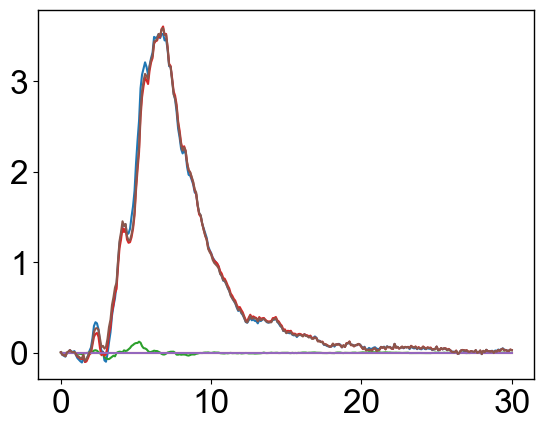

In [5]:
print(df.iloc[0].crystal_system)
for i in range(3):
    for j in range(i,3):
        plt.plot(df.iloc[0]["energies_interp"], df.iloc[0]["y_pred_cart"][:,i,j])
plt.show()

In [6]:
from concurrent.futures import ProcessPoolExecutor
from matplotlib.ticker import MaxNLocator

def get_Kerr_spectra(omega, conductivity_complex):
    kerr_complex = conductivity_complex[:, 0, 2] / (
        conductivity_complex[:, 0, 0] * np.sqrt(1 + 1j * 4 * np.pi / omega * conductivity_complex[:, 0, 0])
    )
    theta_K = kerr_complex.real
    epsilon_K = kerr_complex.imag
    return theta_K, epsilon_K, kerr_complex

def kramers_kronig_tensor(omega_vals, imag_tensor):
    N = len(omega_vals)
    real_tensor = np.zeros_like(imag_tensor)

    for i in range(3):
        for j in range(i, 3):
            chi_im_vals = imag_tensor[:, i, j]
            chi_re_vals = np.zeros(N)

            for k, omega in enumerate(omega_vals):
                integrand = np.zeros(N)
                for l, omega_p in enumerate(omega_vals):
                    if l != k:
                        integrand[l] = (omega_p * chi_im_vals[l]) / (omega_p**2 - omega**2)
                integral = np.trapz(integrand, omega_vals)
                chi_re_vals[k] = (2 / np.pi) * integral

            real_tensor[:, i, j] = chi_re_vals
            if i != j:
                real_tensor[:, j, i] = chi_re_vals
    return real_tensor

def process_row(row_dict):
    row = row_dict.copy()
    imag_permittivity = row["imag_Permittivity_Matrices_interp"]
    pred_imag_permittivity = row["y_pred_cart"]
    omega = row["energies_interp"]

    omega = np.where(omega == 0, np.finfo(float).eps, omega)
    
    real_permittivity = kramers_kronig_tensor(omega, imag_permittivity)
    pred_real_permittivity = kramers_kronig_tensor(omega, pred_imag_permittivity)

    permittivity_complex = real_permittivity + 1j * imag_permittivity
    conductivity_complex = -1j * permittivity_complex / omega[:, np.newaxis, np.newaxis]

    pred_permittivity_complex = pred_real_permittivity + 1j * pred_imag_permittivity
    pred_conductivity_complex = -1j * pred_permittivity_complex / omega[:, np.newaxis, np.newaxis]

    theta_K, epsilon_K, kerr_complex = get_Kerr_spectra(omega, conductivity_complex)
    pred_theta_K, pred_epsilon_K, pred_kerr_complex = get_Kerr_spectra(omega, pred_conductivity_complex)

    row["conductivity_complex"] = conductivity_complex
    row["pred_conductivity_complex"] = pred_conductivity_complex
    row["theta_K"] = theta_K
    row["pred_theta_K"] = pred_theta_K
    row["epsilon_K"] = epsilon_K
    row["pred_epsilon_K"] = pred_epsilon_K
    row["kerr_complex"] = kerr_complex
    row["pred_kerr_complex"] = pred_kerr_complex
    return row

# --- Parallelize over rows ---
def parallel_process_df(df, n_workers=None):
    rows = df.to_dict(orient="records")
    with ProcessPoolExecutor(max_workers=36) as executor:
        results = list(executor.map(process_row, rows))
    return pd.DataFrame(results)

# Usage:
df = parallel_process_df(df)


/tmp/ipykernel_9827/1010811157.py:5: RuntimeWarning: invalid value encountered in divide
  kerr_complex = conductivity_complex[:, 0, 2] / (
/tmp/ipykernel_9827/1010811157.py:5: RuntimeWarning: invalid value encountered in divide
  kerr_complex = conductivity_complex[:, 0, 2] / (
/tmp/ipykernel_9827/1010811157.py:5: RuntimeWarning: invalid value encountered in divide
  kerr_complex = conductivity_complex[:, 0, 2] / (
/tmp/ipykernel_9827/1010811157.py:5: RuntimeWarning: invalid value encountered in divide
  kerr_complex = conductivity_complex[:, 0, 2] / (
/tmp/ipykernel_9827/1010811157.py:5: RuntimeWarning: invalid value encountered in divide
  kerr_complex = conductivity_complex[:, 0, 2] / (
/tmp/ipykernel_9827/1010811157.py:5: RuntimeWarning: invalid value encountered in divide
  kerr_complex = conductivity_complex[:, 0, 2] / (
/tmp/ipykernel_9827/1010811157.py:5: RuntimeWarning: invalid value encountered in divide
  kerr_complex = conductivity_complex[:, 0, 2] / (
/tmp/ipykernel_9827/

In [7]:
df["pred_theta_K_max"] = df["pred_theta_K"].apply(lambda x: np.nanmax(np.abs(x)))
# df["theory_theta_K_max"] = df["theta_K"].apply(lambda x: np.nanmax(np.abs(x)))

df["pred_theta_K_max_loc"] = df["pred_theta_K"].apply(lambda x: np.nanargmax(np.abs(x)))
# df["theory_theta_K_max_loc"] = df["theta_K"].apply(lambda x: np.nanargmax(np.abs(x)))

# Use the max location to index the corresponding omega point
df["pred_theta_K_max_omega"] = df.apply(lambda row: row["energies_interp"][row["pred_theta_K_max_loc"]], axis=1)
# df_filtered = df[df["crystal_system"] != "triclinic"]

### This is just a demonstration. In a realistic scenario, one should consider the magnetic-field-induced off-diagonal components rather than the intrinsic ones.
### We want to demo how to use the pretrained model to perform the material discovery


Material with **2nd largest** |θ_K| in low energy range:
MP ID: mp-570538
Formula: N6Na2
Crystal System: monoclinic
Max |θ_K| = 4.6677 at ω = 4.40 eV


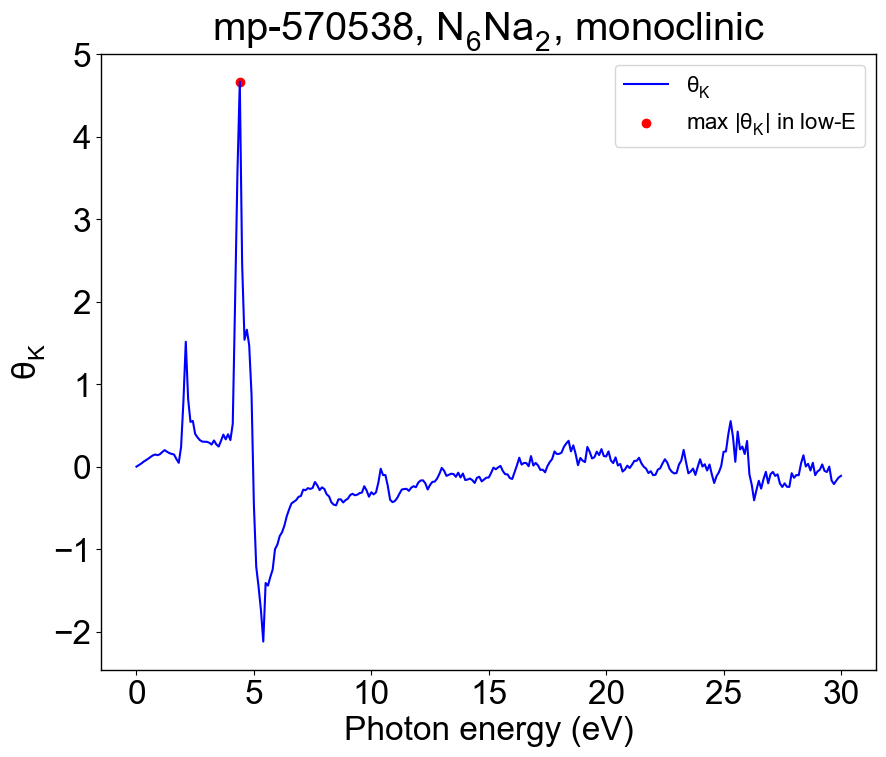

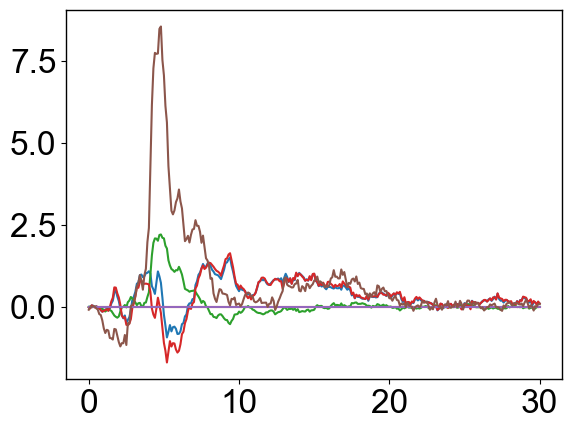

In [8]:
low_energy_threshold = 10.0  # eV

# Filter: only include those whose max ω is in the low-energy regime
df_low_energy_peak = df[df["pred_theta_K_max_omega"] < low_energy_threshold]

# Sort by max |theta_K| in descending order
df_low_energy_peak_sorted = df_low_energy_peak.sort_values("pred_theta_K_max", ascending=False)

best_row = df_low_energy_peak_sorted.iloc[1]  # second largest
print("Material with **2nd largest** |θ_K| in low energy range:")
print(f"MP ID: {best_row['mp_id']}")
print(f"Formula: {best_row['formula']}")
print(f"Crystal System: {best_row['crystal_system']}")
print(f"Max |θ_K| = {best_row['pred_theta_K_max']:.4f} at ω = {best_row['pred_theta_K_max_omega']:.2f} eV")

omega = best_row["energies_interp"]
theta_K = best_row["pred_theta_K"]
formula = format_chemical_formula(best_row["formula"])
crystal_sys = best_row["crystal_system"]

idx_max = best_row["pred_theta_K_max_loc"]
theta_K_max_value = best_row["pred_theta_K"][idx_max]
omega_max_value = best_row["energies_interp"][idx_max]

plt.figure(figsize=(10, 8))
plt.plot(omega, theta_K, label=r"$\theta_K$", color='blue')
plt.scatter([omega_max_value], [theta_K_max_value],
            color='red', label=r'max $|\theta_K|$ in low-E')
plt.xlabel("Photon energy (eV)")
plt.ylabel(r"$\theta_K$")
plt.title(f"{best_row.mp_id}, ${formula}$, {crystal_sys}")
plt.legend()
plt.show()

for i in range(3):
    for j in range(i, 3):
        plt.plot(best_row["energies_interp"], best_row["y_pred_cart"][:, i, j])
plt.show()

